In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['axes.grid'] = True

In [2]:
import pandas as pd
import pandas_datareader as pdr

* 국제 금가격 (런던 금시장)
* Gold Fixing Price in London Bullion Market (based in U.S. Dollar)

* (HSBC, 도이치은행 등) 5개 은행이 회의를 통해 Gold Fixing Price 발표
* 하루에 두 번 (10:30 AM, 3:00 PM 런던시간)
* FRED (세인트루이스 연방준비은행 경제 데이터)

-  https://fred.stlouisfed.org/series/GOLDAMGBD228NLBM 
- https://fred.stlouisfed.org/series/GOLDPMGBD228NLBM

In [54]:
df_gold = pdr.DataReader('GOLDAMGBD228NLBM', 'fred', start='2000-01-01')
print(type(df_gold))
print('row count:', len(df_gold))
df_gold[.tail(10)]

SyntaxError: invalid syntax (<ipython-input-54-080dea10a8f2>, line 4)

142.85714285714286


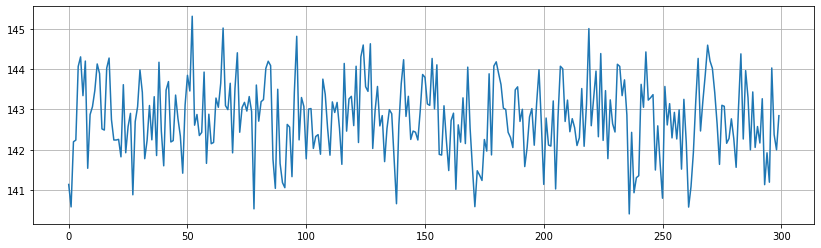

In [55]:
# 일반 숫자로 그래프 그려보기
ar_process = []
y = 140
coff = 0.3
const = 100
for i in range(300):
 error = np.random.randn()
 y = const + y * coff + error
 ar_process.append(y)
print(const / (1 - coff))
plt.plot(ar_process)

            GOLDAMGBD228NLBM
DATE                        
2000-01-03               NaN
2000-01-04        282.050000
2000-01-05        282.075000
2000-01-06        281.500000
2000-01-07        281.625000
...                      ...
2021-07-14       1817.660983
2021-07-15       1817.170809
2021-07-16       1816.442775
2021-07-19       1815.551445
2021-07-20       1815.206936

[5622 rows x 1 columns]


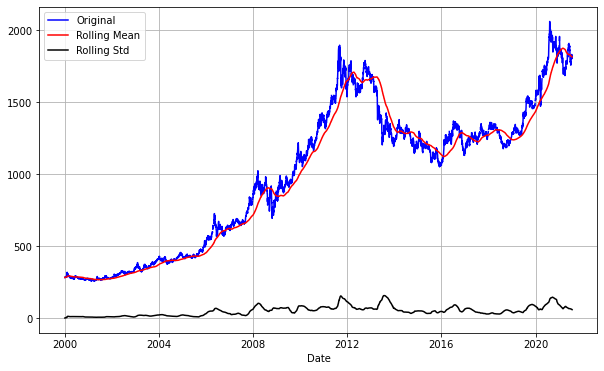

In [56]:
# 함수 만들기
def plot_rolling(data, interval):
    rolmean = data.rolling(interval, min_periods=1).mean()
    rolstd = data.rolling(interval, min_periods=1).std()
    print(rolmean)
    #Plot rolling statistics:
    plt.figure(figsize=(10, 6))
    plt.xlabel('Date')
    orig = plt.plot(data, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show()
plot_rolling(df_gold, 180)

In [52]:
!pip install statsmodels

You should consider upgrading via the 'c:\users\82108\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [61]:
from statsmodels.tsa.stattools import adfuller
y = df_gold['GOLDAMGBD228NLBM']
y_1diff = df_gold.diff().dropna()['GOLDAMGBD228NLBM']
y_1diff
result = adfuller(y_1diff)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}')
result = adfuller(y_1diff)
print(f'1차 차분 ADF Statistic: {result[0]:.3f}')
print(f'1차 차분 p-value: {result[1]:.3f}')

원 데이터 ADF Statistic: -14.352
원 데이터 p-value: 0.000
1차 차분 ADF Statistic: -14.352
1차 차분 p-value: 0.000


In [71]:
from statsmodels.tsa.arima_model import ARIMA

def my_auto_arima(data, order,sort = 'AIC'):
    order_list = []
    aic_list = []
    bic_lsit = []
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p,d,q))
                try:
                    model_fit = model.fit()
                    c_order = f'p{p} d{d} q{q}'
                    aic = model_fit.aic
                    bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    bic_list.append(bic)
                except:
                    pass
    result_df = pd.DataFrame(list(zip(order_list, aic_list)),columns=['order','AIC'])
    result_df.sort_values(sort, inplace=True)
    return result_df

In [74]:
import warnings
warnings.simplefilter("ignore")
arima_anal = my_auto_arima(y_1diff,[3,3,3])
print(arima_anal)

       order           AIC
10  p1 d0 q1  41479.744277
0   p0 d0 q0  41480.204684
18  p2 d0 q2  41481.646881
1   p0 d0 q1  41482.135822
9   p1 d0 q0  41482.136353
17  p2 d0 q1  41483.794834
11  p1 d0 q2  41483.801059
4   p0 d1 q1  41483.851032
2   p0 d0 q2  41484.053584
16  p2 d0 q0  41484.056209
5   p0 d1 q2  41485.788346
13  p1 d1 q1  41485.801690
14  p1 d1 q2  41486.077757
21  p2 d1 q2  41487.633852
20  p2 d1 q1  41487.763423
8   p0 d2 q2  41522.720623
19  p2 d1 q0  43001.942135
12  p1 d1 q0  43648.088740
3   p0 d1 q0  45171.833156
7   p0 d2 q1  45174.909472
22  p2 d2 q0  46292.158386
15  p1 d2 q0  47896.469918
6   p0 d2 q0  50993.481884


                             ARIMA Model Results                              
Dep. Variable:     D.GOLDAMGBD228NLBM   No. Observations:                 5309
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -20737.817
Method:                       css-mle   S.D. of innovations             12.018
Date:                Wed, 21 Jul 2021   AIC                          41487.634
Time:                        15:56:48   BIC                          41527.097
Sample:                             1   HQIC                         41501.423
                                                                              
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -3.734e-05      0.000     -0.350      0.727      -0.000       0.000
ar.L1.D.GOLDAMGBD228NLBM    -0.8989      0.170     -5.277      0.000      -1.233      -0.

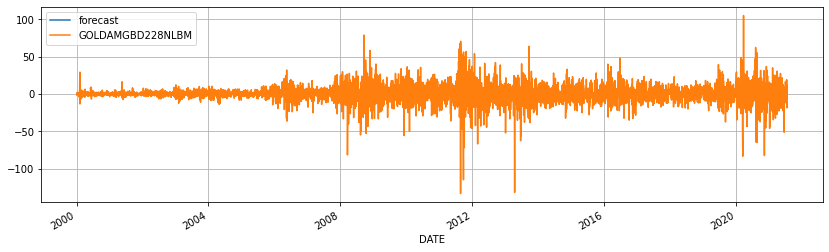

In [99]:
model = ARIMA(y_1diff, (2,1,2))
model_fit = model.fit()
print(model_fit.summary())
model_fit.plot_predict()
plt.show()

In [77]:
!pip install time

ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time
You should consider upgrading via the 'c:\users\82108\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


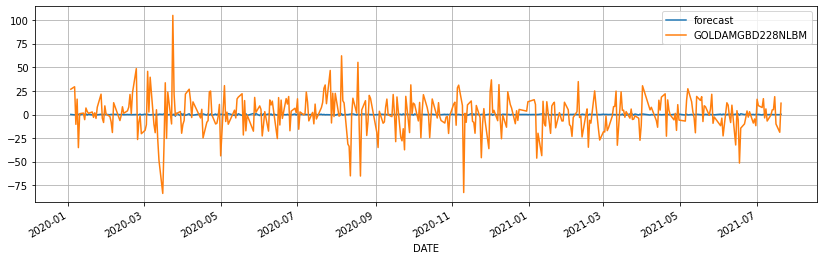

In [107]:
import datetime
model_fit.plot_predict(start=datetime.datetime(2020,1,3))
plt.show()

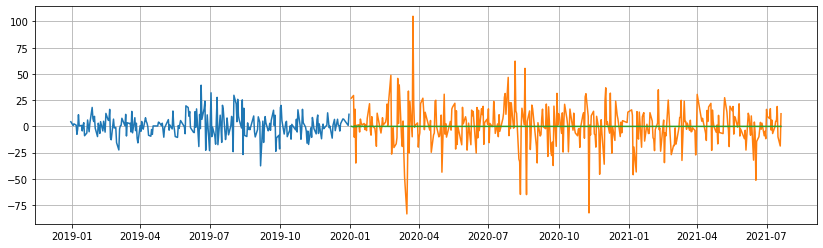

In [108]:
train, test = df_gold.loc[:datetime.datetime(2019,12,31),:].diff().dropna(), df_gold.loc[datetime.datetime(2019,12,31):,:].diff().dropna()
train
model = ARIMA(train,(2,1,2))
model_fit = model.fit()
full_forecast = model_fit.forecast(steps=test.shape[0])
forecast = pd.DataFrame(full_forecast[0], index=test.index, columns=test.columns)
plt.plot(train.loc[datetime.datetime(2018,12,31):,:])
plt.plot(test)
plt.plot(forecast)